In [3]:
import matplotlib as mpl

fs = 10
mpl.rcParams.update({
    "text.usetex": True,                   # Use LaTeX for all text
    "font.family": "serif",                # Use a serif font
    "font.serif": ["Times", "Computer Modern Roman"],  # Common physics fonts
    #"axes.labelsize": fs,                   # Axis labels size
    #"axes.titlesize": fs,                   # Title size
    #"font.size": fs,                        # General font size
    #"legend.fontsize": fs-2,                   # Legend font size
    #"xtick.labelsize": fs-2,                   # X-axis tick size
    #"ytick.labelsize": fs-2,                   # Y-axis tick size
    "axes.linewidth": 1.0,                   # Thickness of axes
    "legend.frameon": False,                 # No legend frame
    "xtick.direction": "in",                  # Ticks inside the plot
    "ytick.direction": "in",
    "xtick.major.size": 5,                    # Major tick size
    "ytick.major.size": 5,
    "xtick.minor.size": 3,                    # Minor tick size
    "ytick.minor.size": 3,
    "xtick.minor.visible": True,              # Show minor ticks
    "ytick.minor.visible": True,
    "grid.linestyle": "--",                   # Dashed grid lines
    "grid.alpha": 0.6,                        # Grid transparency
    "grid.color": "gray",                     # Grid color
})

In [4]:
import warnings
import numpy as np
from scipy.integrate import solve_ivp

class Bloch_Simulator() : 
                                        
    def __init__(self, gamma = 2.675 * 1e8,         # rad/(T*s) 
                    T1 = 1000*1e-3, T2=1000*1e-3,   # s 
                    M0 = 1.0, 
                    phi = 0.0, 
                    omega_1 = 0.25 * 1e4,           # 1/s 
                    delta_omega = 0.0,              # 1/s 
                    nz = 1.0,                       # nmb. 
                    tw = 1 * 1e-3,                  # s 
                    G = None, 
                    lower_bound=-np.inf, upper_bound=np.inf
                )  -> None:
        # Constants
        self.delta_x = 2 * 1e-3                     # m
        # Parameters
        self.gamma = gamma
        self.T1 = T1
        self.T2 = T2
        self.M0 = M0
        self.phi = phi
        self.omega_1 = omega_1
        self.delta_omega = delta_omega
        self.nz = nz
        self.tw = tw
        if(G is None) : self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)
        else :  self.G = G
        # Pulse bounds
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        # Logged information
        self.last_solution = None
    
    def set_normal_G(self) : 
        self.G = 2*np.pi/(self.gamma*self.tw*self.delta_x)


    def _get_Beff(self, t: float, x: float, apply_sinc: bool)  -> np.ndarray:
        B1 = self._get_omega1(t) / self.gamma
        Beff = np.zeros(3)
        
        Beff[0] += B1*np.cos(self.phi)
        Beff[1] += B1*np.sin(self.phi)
        Beff[2] += self.delta_omega/self.gamma

        if(apply_sinc) : Beff *= np.sin(2*np.pi*t/self.tw)/(2*np.pi*t/self.tw)

        if(x) : Beff[2] += self.G * x

        return Beff


    def _get_omega1(self, t: float) -> float: 
        
        if(t >= self.lower_bound and t <= self.upper_bound) : 
            return self.omega_1
        else : 
            return 0
    
    def _diff_eqn(self, t: float, M: list, x: float, apply_sinc: bool) -> np.ndarray: 
        
        
        M = np.array(M)
        Beff = self._get_Beff(t, x, apply_sinc)
        
        # Precession
        dMdt = - self.gamma * np.cross(M, Beff)

        # Relaxation terms
        dMdt[0] += - 1/self.T2 * M[0]
        dMdt[1] += - 1/self.T2 * M[1]
        dMdt[2] += - 1/self.T1 * (M[2] - self.M0)

        return dMdt

    def solve_ivp(self, dt: float, tlin: list, x: float, apply_sinc=True, force_max_step_size=False) : # -> OdeResult
        M0_init = np.array([0.0, 0.0, self.M0])

        solve_kwargs = {
            "fun": self._diff_eqn,
            "y0": M0_init,
            "t_span": (min(tlin), max(tlin)),
            "t_eval": tlin,
            "args": (x,apply_sinc,)
        }

        if(force_max_step_size) : solve_kwargs["max_step"] = dt 

        solution = solve_ivp(**solve_kwargs)
                    
        self.last_solution = solution

        if not solution.success : warnings.warn(solution.message, UserWarning)

        return solution
        

In [5]:
def do_plot(ax, Ls, Mps, Ms) : 
    ax[0].plot(Ls, Mps, '-')
    ax[0].set_xlabel("Position, x (m)")
    ax[0].set_ylabel("Transverse magnetization, $M_{+}$")

    ax[1].plot(Ls, Ms[:,2], '-')
    ax[1].set_xlabel("Position, x (m)")
    ax[1].set_ylabel("Longitudinal magnetization, $M_{z}$")

    for a in ax : a.grid(alpha=0.4)

In [6]:
import matplotlib.pyplot as plt

Find the value of b1 that produces a π/2-pulse with nz = 1 and tw = 1 ms.

In [7]:
gamma = 2.675 * 1e8 # rad/(T*s)
T1 = 1000*1e-3
T2 = 1000*1e-3 
M0 = 1.0
phi = np.pi/4
delta_omega = 0.0 

delta_x = 2*1e-3 # mm
tw = 1e-3 # s
nz = 1
bound = 0.5*nz*tw 

G = 2*np.pi/(gamma*tw*delta_x)

omegas = np.linspace(0.26e4, 0.27e4, 1000)

best_omega = None
best_res = None

for omega in omegas : 

    solver = Bloch_Simulator(omega_1=omega, lower_bound=-bound, upper_bound=bound)

    dt = 0.0001*1e-3 # s
    tlin = np.arange(-2e-3, 2e-3, dt)
    M0_init = [0.0, 0.0, 1.0]

    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

    if(best_omega is None) : 
        best_omega = omega
        best_res = solution.y[2][-1]
    else : 
        if(np.abs(best_res) > np.abs(solution.y[2][-1])) : 
            best_omega = omega
            best_res = solution.y[2][-1]

5.374785223352316e-06
2674.874874874875


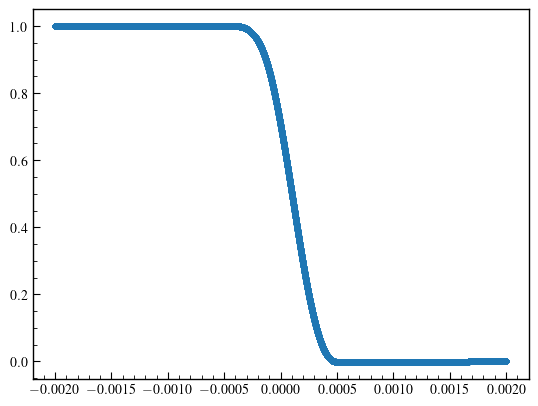

In [8]:
print(best_res)
print(best_omega)

solver = Bloch_Simulator(omega_1=best_omega, lower_bound=-bound, upper_bound=bound)

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)
M0_init = [0.0, 0.0, 1.0]

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

plt.plot(tlin, solution.y[2], '.-')

Plot the magnetization profile |M+(x, t)| vs. x at t = trf/2

In [9]:

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

solver = Bloch_Simulator(omega_1=best_omega, lower_bound=-bound, upper_bound=bound)
trf = solver.nz * solver.tw

dt = 0.0001*1e-3 # s
tlin = np.arange(-2e-3, 2e-3, dt)
M0_init = [0.0, 0.0, 1.0]

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []


for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


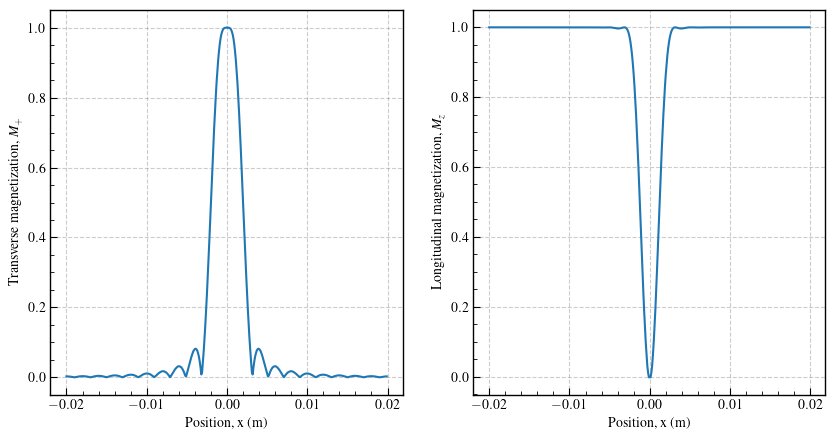

In [10]:
Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)

fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)

How is the profile affected when you vary you double or halve the gradient strength

In [11]:
# G = 2*np.pi/(self.gamma*self.tw*self.delta_x)

length = 2*1e-2 # m
Ls = np.arange(-length, length, 0.01e-2)

solver.G = solver.G * 2

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


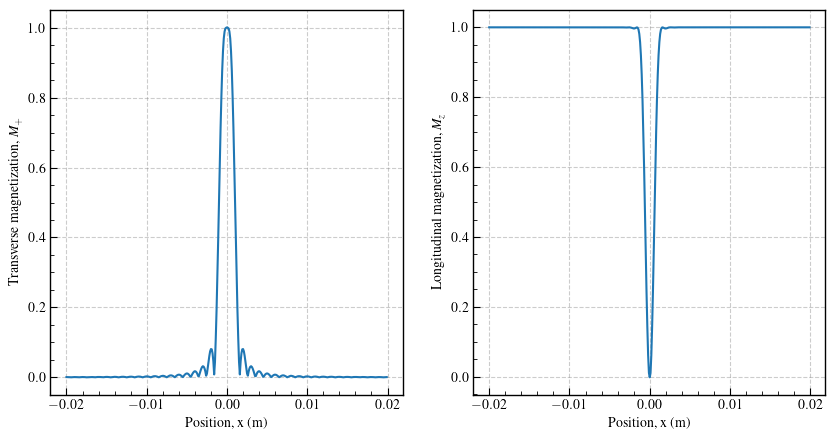

In [12]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


if we increase G, we spatially hit a smaller region of the "scan" and also have higher frequencies. In a time domain the high frequencies will make a shorter pulse, i.e. a shorter slice. 

In [13]:
solver.set_normal_G()
solver.G = solver.G * 0.5

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


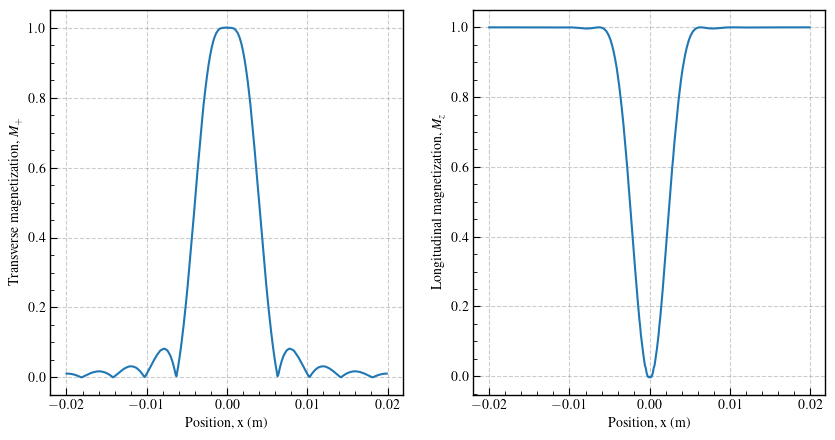

In [14]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)

How would you spatially shift (translate) the slice?

See our drawing. You would change the offset / center frequency of the RF pulse (omega_1). 

How is the profile affected when you vary tw?

You would be capable of performing a larger slice now that the pulse duration is larger.

In [15]:
solver.set_normal_G()
solver.tw = 1*1e-3 # s

solver.tw = 2*1e-3 # s
trf = solver.nz * solver.tw

solver.lower_bound = -0.5 * trf
solver.upper_bound = 0.5 * trf

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


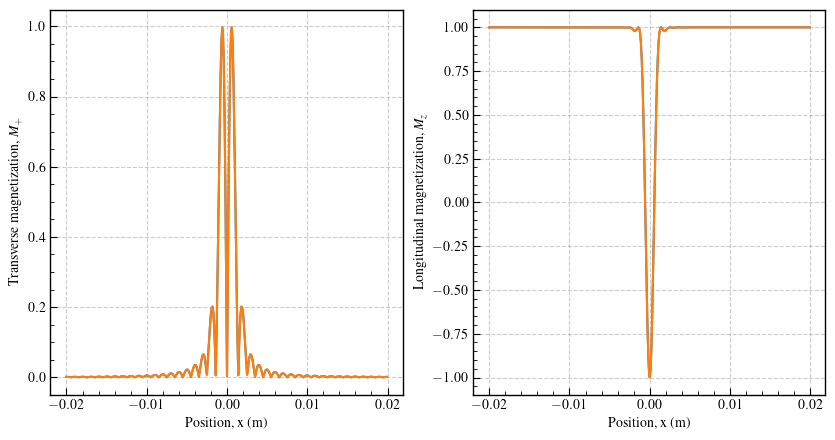

In [16]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)

ax[0].plot(Ls, Mps, '-')
ax[1].plot(Ls, Ms[:,2], '-')

In [17]:
solver.set_normal_G()
solver.tw = 1*1e-3 # s

solver.tw = 0.5*1e-3 # s
trf = solver.nz * solver.tw

solver.lower_bound = -0.5 * trf
solver.upper_bound = 0.5 * trf

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


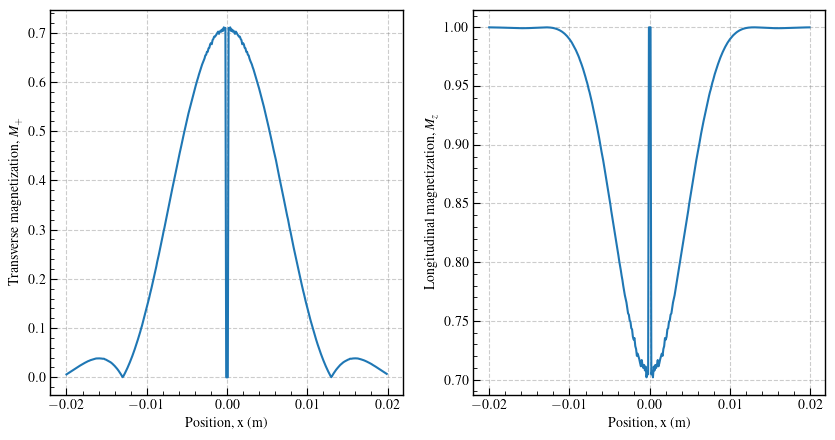

In [18]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)


How is the profile affected when you vary nz?

In [19]:
solver.set_normal_G()
solver.tw = 1*1e-3 # s

solver.nz = 1
solver.nz = 2

trf = solver.nz * solver.tw

solver.lower_bound = -0.5 * trf
solver.upper_bound = 0.5 * trf

solution = solver.solve_ivp(dt=dt, tlin=tlin, x=0, apply_sinc=True, force_max_step_size=False)

Ms = []

for x in Ls : 
    
    solution = solver.solve_ivp(dt=dt, tlin=tlin, x=x, apply_sinc=True, force_max_step_size=False)

    index = np.where(np.isclose(solution.t, 0.5*trf))[0][0]

    Ms.append( solution.y[:,index] )


Ms = np.array(Ms)

Mps = np.sqrt(Ms[:,0]**2 + Ms[:,1]**2)


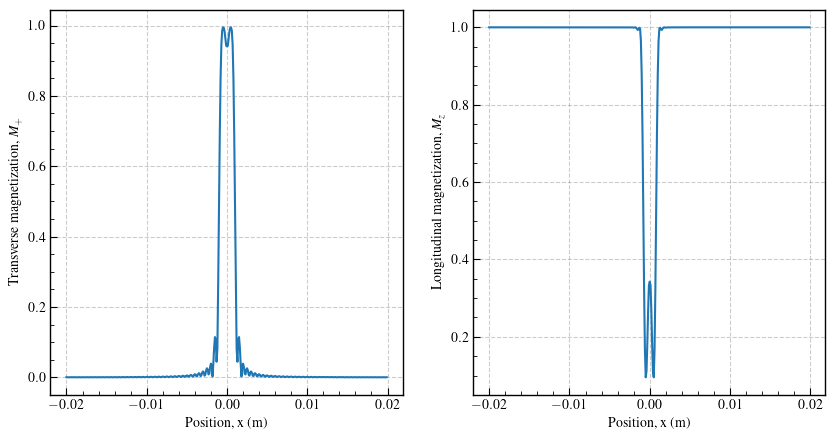

In [22]:
fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

do_plot(ax, Ls, Mps, Ms)

small sinc's from B field we now include give more resonant Larmor frequencies and more interaction leading to funky buisness

In [21]:
from skimage.data import shepp_logan_phantom

c:\Users\Nicolai\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\Nicolai\AppData\Local\Programs\Python\Python311\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


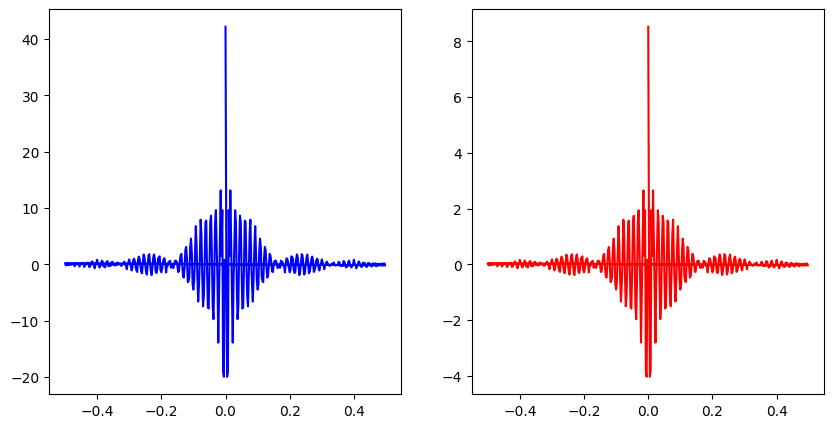

In [127]:
phantom = shepp_logan_phantom()

phantom_1d = phantom[phantom.shape[0] // 2, :]

T2 = 0.01
Te = 16*1e-3    # s

S_k = np.fft.fft(phantom_1d*np.exp(-Te/T2))

fft_M0 = np.fft.fft(phantom_1d)
freq = np.fft.fftfreq(len(phantom_1d))
x = np.linspace(-1, 1, len(phantom_1d))

fig, ax = plt.subplots(1,2, figsize=(2*5, 1*5))

ax[0].plot(freq, fft_M0, 'b-')
ax[1].plot(freq, S_k, 'r-')
#ax[1].plot(x, phantom_1d, 'k--')


by decreasing T_2 we make the exponent negatively larger and therefore e(...) much smaller. So whilst we try to magnetize the brain the spins decay and we lose signal.   

Now take tg = 10 ms, M0(x) = 1 and take T2(x) = 15 ms+ax, with a = .5ms/cm and take Fourier
transform of your signal. What are we seeing? This is a sequence to generate T2 contrast.